In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# NLTK Download for sentiment analysis
nltk.download('vader_lexicon')

# Load dataset
data = pd.read_csv('/content/p1_movie_metadata.csv')

# Handle missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data['plot_keywords'] = data['plot_keywords'].fillna('')  # Fill NaN with empty strings

# Sentiment analysis on plot keywords
sia = SentimentIntensityAnalyzer()
data['plot_keywords'] = data['plot_keywords'].apply(lambda x: ' '.join(str(x).split('|')))
data['sentiment_score'] = data['plot_keywords'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Split and encode genres
data['genres'] = data['genres'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data['genres'])
data = pd.concat([data, pd.DataFrame(genres_encoded, columns=mlb.classes_)], axis=1)

# New Feature Creation
data['profitability'] = data['gross'] - data['budget']
data['return_on_investment'] = (data['profitability'] / data['budget']) * 100
data['popularity_score'] = data['director_facebook_likes'] + data['actor_1_facebook_likes'] + data['actor_2_facebook_likes'] + data['actor_3_facebook_likes']

# Calculate intervals between the releases for each director
data.sort_values(by=['director_name', 'title_year'], inplace=True)
data['single_movie'] = data.groupby('director_name')['title_year'].transform('count') == 1
data['next_release_year'] = data.groupby('director_name')['title_year'].shift(-1)
data['release_interval'] = data['next_release_year'] - data['title_year']
data.loc[data['single_movie'], 'next_release_year'] = -1
data.loc[data['single_movie'], 'release_interval'] = -1
data.dropna(subset=['release_interval'], inplace=True, how='any')

# Prepare features for modeling
numeric_feature_columns = data.select_dtypes(include=[np.number]).columns.tolist()
features_genre = data[numeric_feature_columns]
genres_encoded = data[mlb.classes_].values  # Ensure this is aligned with the current data

# Scaling features for genre prediction
scaler_genre = StandardScaler()
features_scaled_genre = scaler_genre.fit_transform(features_genre)

# Train-test split for genre prediction
X_train_genre, X_test_genre, y_train_genres, y_test_genres = train_test_split(
    features_scaled_genre, genres_encoded, test_size=0.2, random_state=42)

# Genre prediction using Random Forest
genre_classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)
multioutput_classifier = MultiOutputClassifier(genre_classifier_rf)
multioutput_classifier.fit(X_train_genre, y_train_genres)

# Prediction and evaluation for genres
y_pred_genres_rf = multioutput_classifier.predict(X_test_genre)
print("Accuracy on Test Set (Random Forest):", accuracy_score(y_test_genres, y_pred_genres_rf))

# Prepare features for year prediction by including all numeric features
numeric_features = data.select_dtypes(include=[np.number])
features_year_prediction = numeric_features.drop(columns=['release_interval'])
features_year_prediction = numeric_features.drop(columns=['next_release_year'])  # Exclude the target variable

# Defining Target Variable
target_year = data['release_interval'].values

# Scaling features for year prediction
scaler_year = StandardScaler()
features_scaled_year = scaler_year.fit_transform(features_year_prediction)

# Train-test split for year prediction
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
    features_scaled_year, target_year, test_size=0.2, random_state=42)

# Setup for release year prediction using an ensemble of regressors
year_regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)
year_regressor_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

year_regressor_rf.fit(X_train_year, y_train_year)
year_regressor_gb.fit(X_train_year, y_train_year)

# Prediction and evaluation for release year
y_pred_year_rf = year_regressor_rf.predict(X_test_year)
y_pred_year_gb = year_regressor_gb.predict(X_test_year)

print("MSE on Test Set (Random Forest):", mean_squared_error(y_test_year, y_pred_year_rf))
print("MSE on Test Set (Gradient Boosting):", mean_squared_error(y_test_year, y_pred_year_gb))

# Combining predictions (simple averaging)
y_pred_year_ensemble = (y_pred_year_rf + y_pred_year_gb) / 2
print("MSE on Test Set (Ensemble):", mean_squared_error(y_test_year, y_pred_year_ensemble))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy on Test Set (RF): 0.9950556242274413
MSE on Test Set (RF): 0.06332741641734795
MSE on Test Set (GB): 0.04494392708963109
MSE on Test Set (Ensemble): 0.0469960836717365


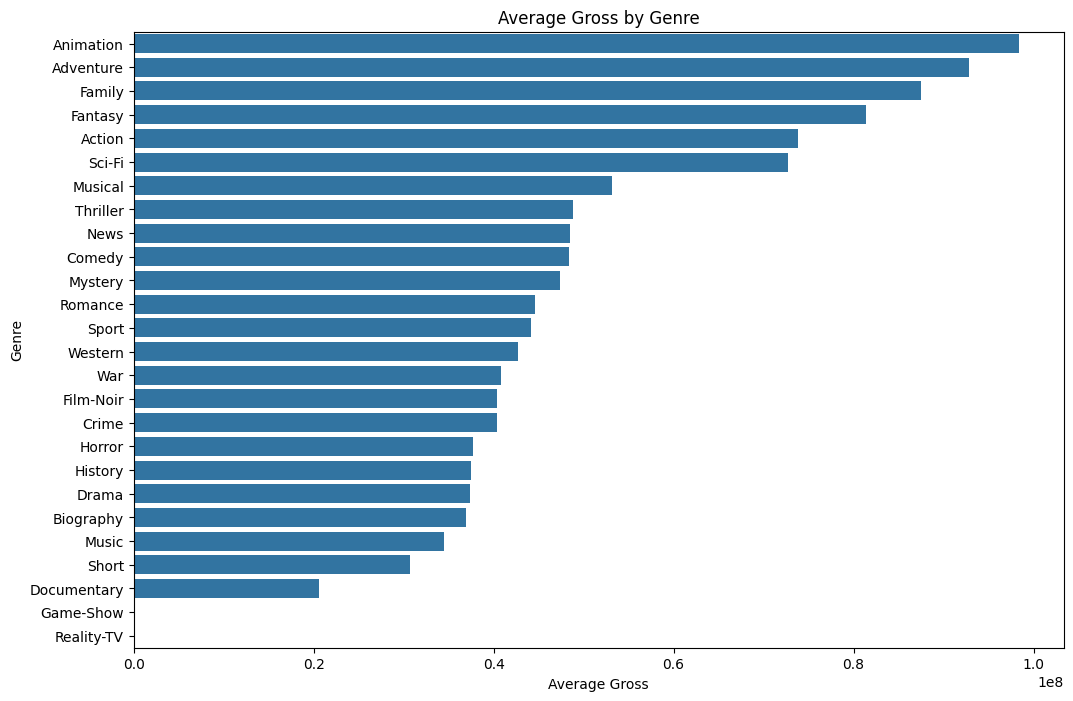

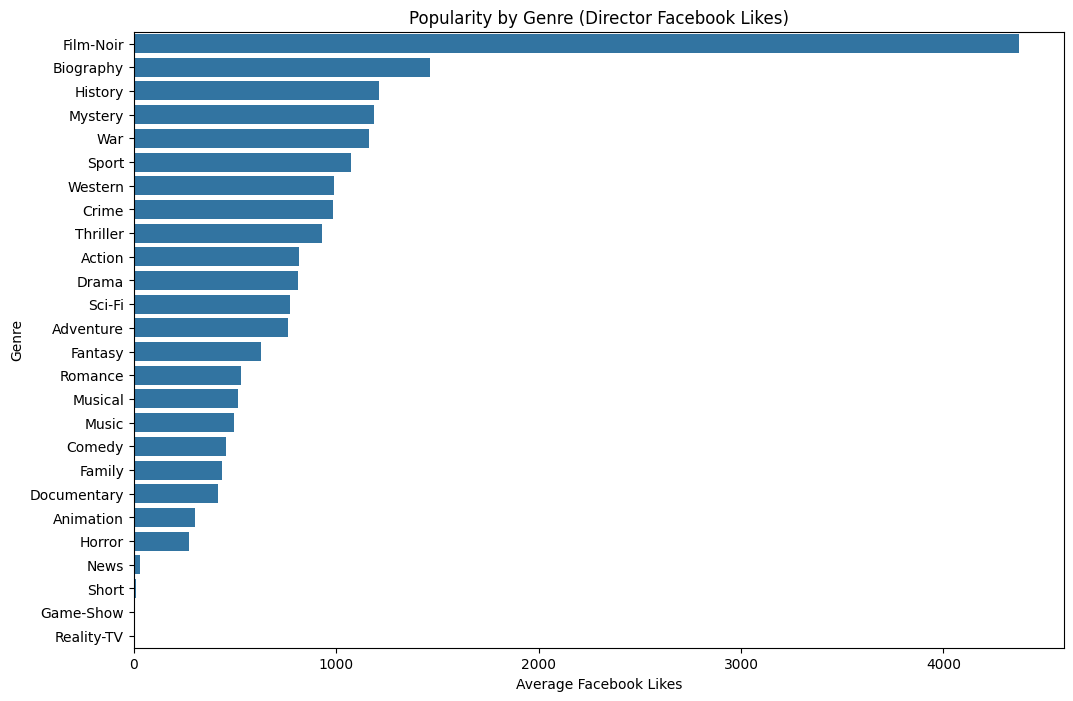

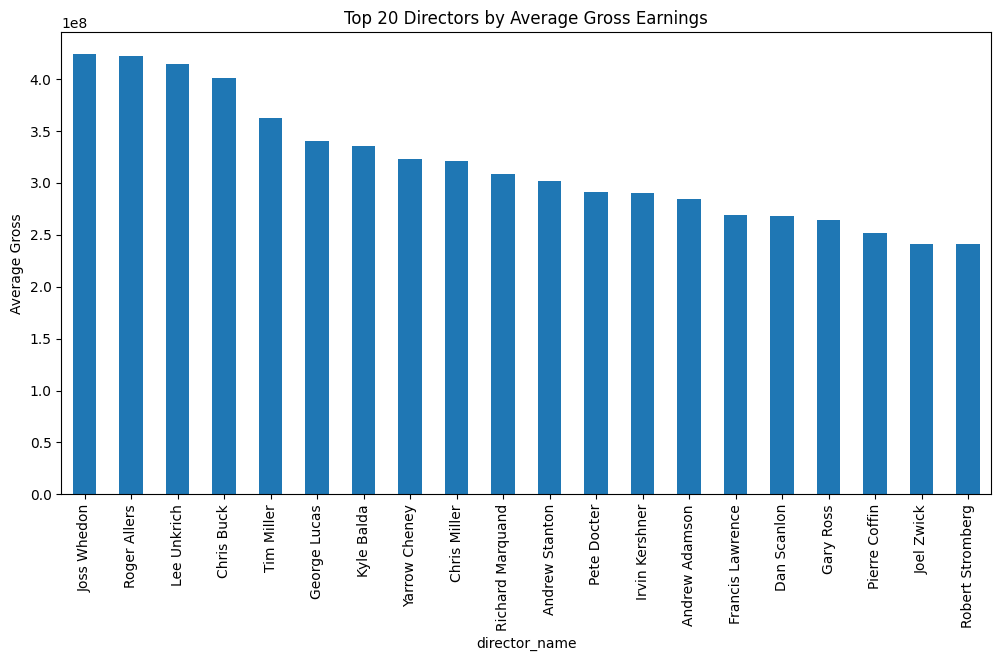

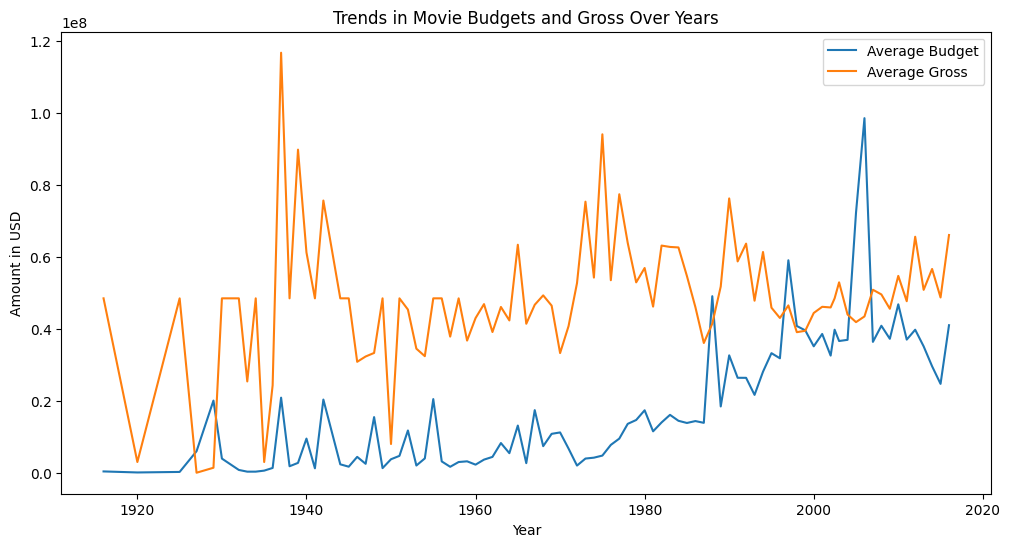

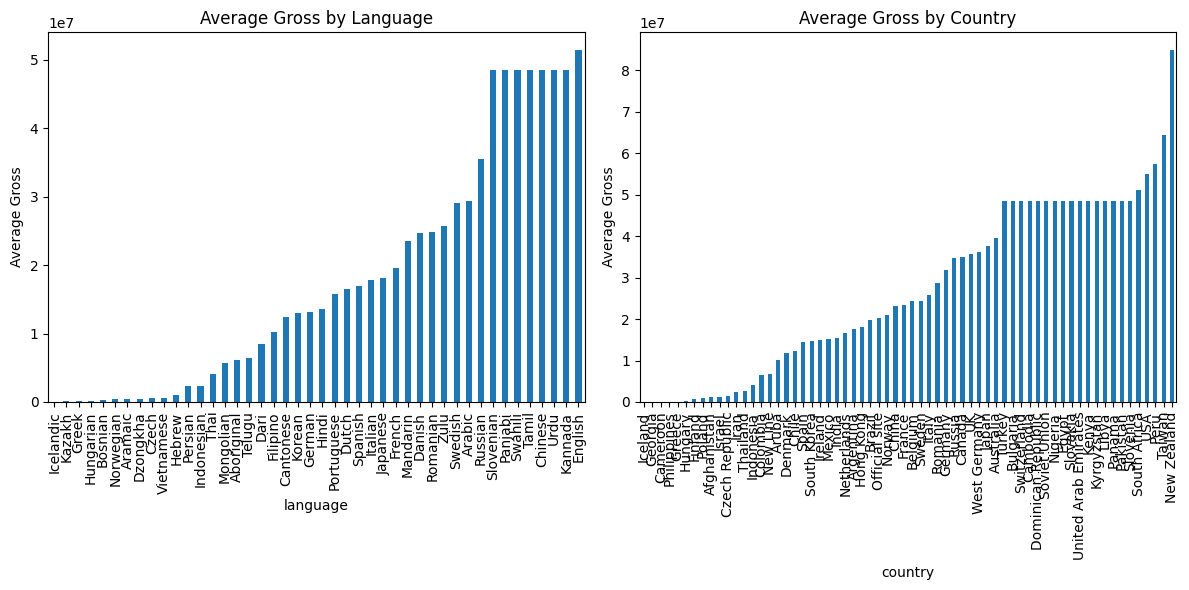

In [ ]:
# Visualization of Feature Relationships and Trends

data['gross'] = pd.to_numeric(data['gross'], errors='coerce')
data['gross'] = data['gross'].fillna(data['gross'].mean())

# Dictionary to store average gross per genre
avg_gross_by_genre = {}

for genre in mlb.classes_:
    # Calculate the weighted average gross for each genre
    # Multiply the gross by the genre indicator and then divide by the sum of the genre indicator
    total_gross = (data[genre] * data['gross']).sum()
    genre_count = data[genre].sum()
    avg_gross_by_genre[genre] = total_gross / genre_count if genre_count else 0

data['director_facebook_likes'] = pd.to_numeric(data['director_facebook_likes'], errors='coerce')
data['director_facebook_likes'] = data['director_facebook_likes'].fillna(data['director_facebook_likes'].mean())

# Dictionary to store average popularity per genre
popularity_by_genre = {}

for genre in mlb.classes_:
    # Calculate the weighted average director_facebook_likes for each genre
    total_likes = (data[genre] * data['director_facebook_likes']).sum()
    genre_count = data[genre].sum()
    popularity_by_genre[genre] = total_likes / genre_count if genre_count else 0

# Director influence on gross and popularity
director_avg_gross = data.groupby('director_name')['gross'].mean()
director_popularity = data.groupby('director_name')['director_facebook_likes'].mean()

# Actor influence - combining the top three actors' Facebook likes
data['total_actor_facebook_likes'] = data['actor_1_facebook_likes'] + data['actor_2_facebook_likes'] + data['actor_3_facebook_likes']
# Ensure actor Facebook like columns are numeric and handle NaNs
data['actor_1_facebook_likes'] = pd.to_numeric(data['actor_1_facebook_likes'], errors='coerce').fillna(0)
data['actor_2_facebook_likes'] = pd.to_numeric(data['actor_2_facebook_likes'], errors='coerce').fillna(0)
data['actor_3_facebook_likes'] = pd.to_numeric(data['actor_3_facebook_likes'], errors='coerce').fillna(0)

# Calculate total actor Facebook likes
data['total_actor_facebook_likes'] = data['actor_1_facebook_likes'] + data['actor_2_facebook_likes'] + data['actor_3_facebook_likes']

# Group by 'movie_title' and calculate the mean of 'total_actor_facebook_likes'
actor_influence = data.groupby('movie_title')['total_actor_facebook_likes'].mean()

# Temporal trends in budgets and gross
yearly_budget = data.groupby('title_year')['budget'].mean()
yearly_gross = data.groupby('title_year')['gross'].mean()

# Language and country impact
gross_by_language = data.groupby('language')['gross'].mean()
gross_by_country = data.groupby('country')['gross'].mean()

avg_gross_df = pd.DataFrame(list(avg_gross_by_genre.items()), columns=['Genre', 'Average Gross'])

# Sort the DataFrame by 'Average Gross'
avg_gross_df = avg_gross_df.sort_values(by='Average Gross', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Average Gross', y='Genre', data=avg_gross_df)
plt.title('Average Gross by Genre')
plt.xlabel('Average Gross')
plt.ylabel('Genre')
plt.show()

popularity_genre_df = pd.DataFrame(list(popularity_by_genre.items()), columns=['Genre', 'Average Facebook Likes'])

# Sort the DataFrame by 'Average Facebook Likes'
popularity_genre_df = popularity_genre_df.sort_values(by='Average Facebook Likes', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Average Facebook Likes', y='Genre', data=popularity_genre_df)
plt.title('Popularity by Genre (Director Facebook Likes)')
plt.xlabel('Average Facebook Likes')
plt.ylabel('Genre')
plt.show()

# Visualization of Director Influence on Gross
plt.figure(figsize=(12, 6))
director_avg_gross.sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Directors by Average Gross Earnings')
plt.ylabel('Average Gross')
plt.show()

# Visualization of Temporal Trends in Movie Budgets and Gross
plt.figure(figsize=(12, 6))
yearly_budget.plot(label='Average Budget')
yearly_gross.plot(label='Average Gross')
plt.legend()
plt.title('Trends in Movie Budgets and Gross Over Years')
plt.xlabel('Year')
plt.ylabel('Amount in USD')
plt.show()

# Visualization of Average Gross by Language and Country
plt.figure(figsize=(12, 6))
plt.subplot(121)
gross_by_language.sort_values().plot(kind='bar')
plt.title('Average Gross by Language')
plt.ylabel('Average Gross')

plt.subplot(122)
gross_by_country.sort_values().plot(kind='bar')
plt.title('Average Gross by Country')
plt.ylabel('Average Gross')
plt.tight_layout()
plt.show()



In [ ]:
def predict_movie_features(director_name):

    # Load dataset again to get latest release
    data1 = pd.read_csv('/content/p1_movie_metadata.csv')
    data1.sort_values(by=['director_name', 'title_year'], inplace=True)
    director_data1 = data1[data1['director_name'] == director_name]
    latest_movie1 = director_data1.sort_values(by='title_year', ascending=False).iloc[0] # Latest movie (real)

    # Check if the director is in the dataset
    if director_name not in data['director_name'].values:
        return "Director not found in the dataset."

    # Prepare the director's data for prediction
    director_data = data[data['director_name'] == director_name]
    if director_data.empty:
        return "No data available for this director."

    # Sort the data by year and get the latest movie
    latest_movie = director_data.sort_values(by='title_year', ascending=False).iloc[0] # Latest movie with the updated features

    # Construct a DataFrame with all relevant feature columns for genre prediction
    features_for_genre = latest_movie[numeric_feature_columns].to_frame().transpose()

    # Scaling features for genre prediction
    scaled_features_genre = scaler_genre.transform(features_for_genre)

    # Making predictions for genres
    predicted_genres_rf = multioutput_classifier.predict(scaled_features_genre)
    predicted_genres = mlb.classes_[(predicted_genres_rf > 0.5).flatten()]  # Adjust threshold as needed

    features_for_year = latest_movie[features_year_prediction.columns].to_frame().transpose()

    # Scaling features for year prediction
    scaled_features_year = scaler_year.transform(features_for_year)

    # Making predictions for year interval
    predicted_interval_rf = year_regressor_rf.predict(scaled_features_year)
    predicted_interval_gb = year_regressor_gb.predict(scaled_features_year)

    # Simple averaging for ensemble prediction of the interval
    predicted_interval_ensemble = (predicted_interval_rf + predicted_interval_gb) / 2

    # Calculate the predicted release year by adding the interval to the latest movie's year
    predicted_release_year = latest_movie1['title_year'] + round(predicted_interval_ensemble[0])
    # print(latest_movie1['title_year'])
    # print (predicted_interval_ensemble[0])

    return predicted_release_year, predicted_genres

# Example usage
director_name = input('Enter name of the director.\n')
predicted_year, predicted_genres = predict_movie_features(director_name)
print(f"Predicted Release Year: {predicted_year}")
print("Predicted Genres:", ', '.join(predicted_genres))


2014.0
2.000003470696922
Predicted Release Year: 2016.0
Predicted Genres: Action, Thriller
